In [4]:
# === Cell 0: Imports and Dataset Paths

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

# === Set dataset paths
ORIGINAL_DATASET_DIR = './dataset_2'       # Original MRI dataset
GAN_DATASET_DIR = './gan_augmented'        # GAN-augmented MRI dataset

# === Sanity check
print("Original dataset path exists:", os.path.exists(ORIGINAL_DATASET_DIR))
print("GAN dataset path exists:", os.path.exists(GAN_DATASET_DIR))


Original dataset path exists: True
GAN dataset path exists: True


In [5]:
# === Cell 1: Load Datasets Separately ===

BATCH_SIZE = 32
IMG_SIZE = (224, 224)
SEED = 123

# Load original dataset
original_ds = tf.keras.preprocessing.image_dataset_from_directory(
    ORIGINAL_DATASET_DIR,
    label_mode='categorical',     # Use 'int' if your model uses sparse_categorical_crossentropy
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

# Load GAN-augmented dataset
gan_ds = tf.keras.preprocessing.image_dataset_from_directory(
    GAN_DATASET_DIR,
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

# Print class names for reference
class_names = original_ds.class_names
print("Class names:", class_names)


Found 480 files belonging to 4 classes.
Found 400 files belonging to 4 classes.
Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']


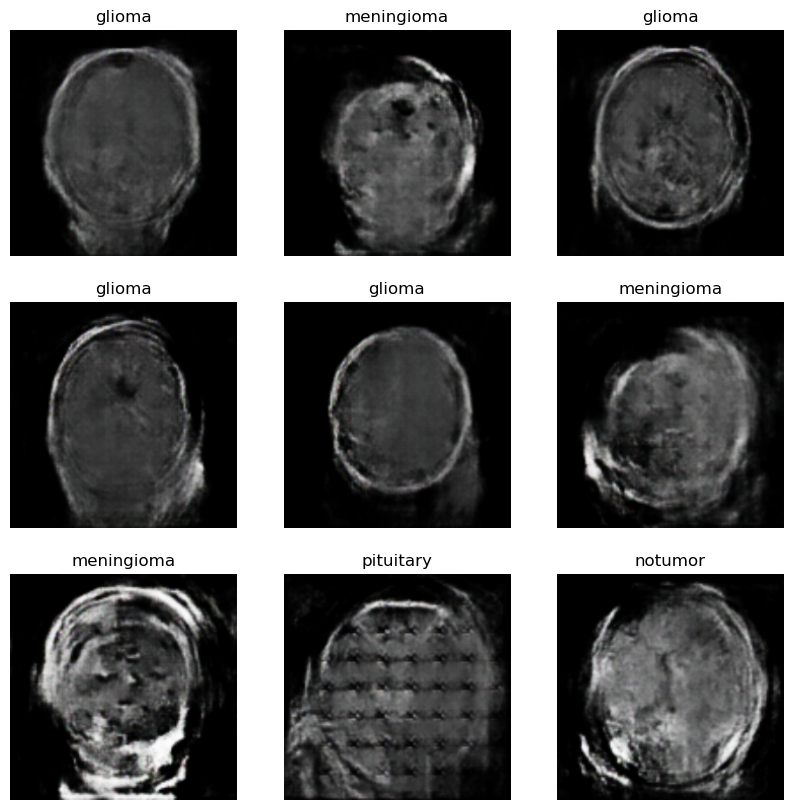

In [9]:
# === Cell 2: Combine and Prepare Dataset ===

# Concatenate the original and GAN datasets
combined_ds = original_ds.concatenate(gan_ds)

# Shuffle and prefetch the combined dataset
combined_ds = combined_ds.shuffle(buffer_size=1000, seed=SEED)
combined_ds = combined_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# Optional: Inspect a few samples to confirm
for images, labels in combined_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")


In [10]:
# === Cell 3: Build EfficientNetB0 Model ===

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Define number of classes based on the dataset
NUM_CLASSES = len(class_names)

# Build model
base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')  # use 'sigmoid' for binary, 'softmax' for multi-class
])

# Freeze base model for initial training
base_model.trainable = False

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',  # use 'sparse_categorical_crossentropy' if using integer labels
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [11]:
# === Cell 4: Train the Model ===

EPOCHS = 10

history = model.fit(
    combined_ds,
    epochs=EPOCHS,
    verbose=1
)


Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 28s 618ms/step - accuracy: 0.3720 - loss: 1.3352
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 444ms/step - accuracy: 0.7430 - loss: 0.7939
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 439ms/step - accuracy: 0.8130 - loss: 0.5949
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 433ms/step - accuracy: 0.8143 - loss: 0.5398
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 434ms/step - accuracy: 0.8829 - loss: 0.4376
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 504ms/step - accuracy: 0.9101 - loss: 0.3515
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 449ms/step - accuracy: 0.8897 - loss: 0.3666
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 469ms/step - accuracy: 0.9168 - loss: 0.2882
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 468ms/step - accuracy: 0.9317 - loss: 0.2549
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 452ms/step - accuracy: 0.9305 - loss: 0.2289


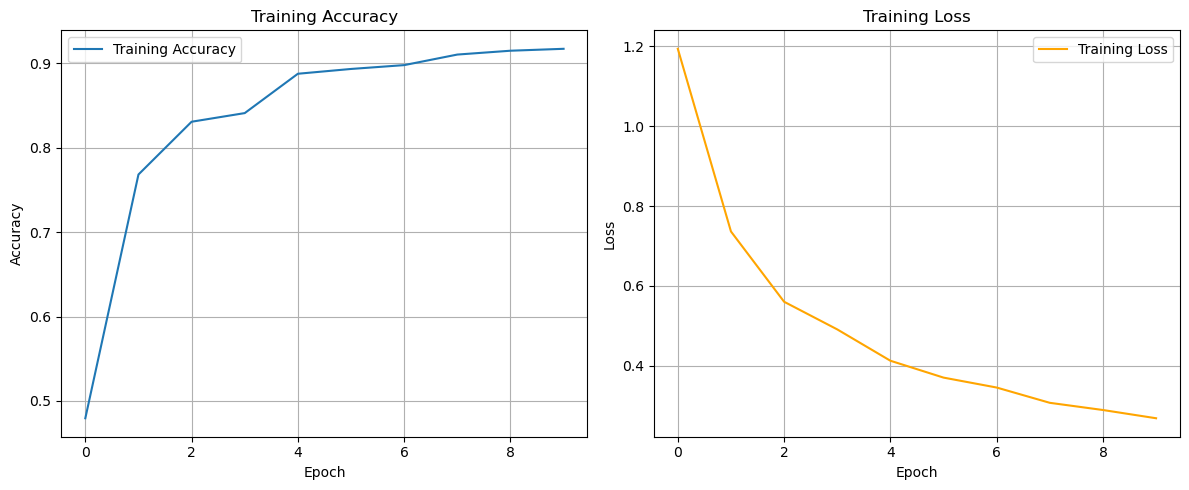

In [12]:
# === Cell 5: Plot Training Metrics ===

acc = history.history['accuracy']
loss = history.history['loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='orange')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [14]:
# === Define a test dataset using part of the original dataset (for demo/comparison) ===

TEST_DATASET_DIR = ORIGINAL_DATASET_DIR  # Ideally should be a separate 'test' folder

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DATASET_DIR,
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False  # <-- important for evaluation
)


Found 480 files belonging to 4 classes.


15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 485ms/step
✅ Classification Report:
              precision    recall  f1-score   support

      glioma       0.95      0.91      0.93       120
  meningioma       0.85      0.80      0.82       120
     notumor       0.87      0.97      0.92       120
   pituitary       0.97      0.94      0.95       120

    accuracy                           0.91       480
   macro avg       0.91      0.91      0.91       480
weighted avg       0.91      0.91      0.91       480



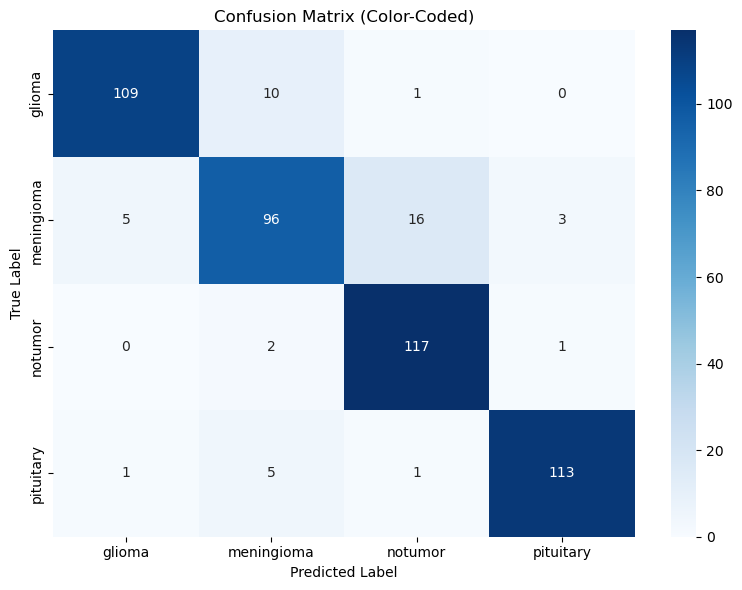

In [15]:
# === Cell 6: Evaluate on Real Test Dataset ===

from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns

# === Prepare test data ===
# If not yet loaded:
# test_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     './real_validation_set',
#     image_size=IMG_SIZE,
#     batch_size=BATCH_SIZE,
#     label_mode='categorical',
#     shuffle=False
# )

# Get true and predicted labels
y_true = np.concatenate([y.numpy() for x, y in test_ds])
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_true, axis=1)

# === Classification Report
print("✅ Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# === Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Confusion Matrix (Color-Coded)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()
